In [52]:
library(tidyverse)
library(lubridate)

players_url  <- "https://raw.githubusercontent.com/Samwich1213/Project-planning/main/players.csv"
sessions_url <- "https://raw.githubusercontent.com/Samwich1213/Project-planning/main/sessions.csv"

players  <- readr::read_csv(players_url,  show_col_types = FALSE)
sessions <- readr::read_csv(sessions_url, show_col_types = FALSE)

tibble(dataset = c("players","sessions"),
       n_rows  = c(nrow(players), nrow(sessions)),
       n_cols  = c(ncol(players), ncol(sessions)))

dataset,n_rows,n_cols
<chr>,<int>,<int>
players,196,7
sessions,1535,5


In [53]:
tibble(variable = names(players),
       type = map_chr(players, ~ class(.x)[1])) |> print(n = Inf)

tibble(variable = names(sessions),
       type = map_chr(sessions, ~ class(.x)[1])) |> print(n = Inf)

# A tibble: 7 × 2
  variable     type     
  <chr>        <chr>    
1 experience   character
2 subscribe    logical  
3 hashedEmail  character
4 played_hours numeric  
5 name         character
6 gender       character
7 Age          numeric  
# A tibble: 5 × 2
  variable            type     
  <chr>               <chr>    
1 hashedEmail         character
2 start_time          character
3 end_time            character
4 original_start_time numeric  
5 original_end_time   numeric  


In [54]:
players |>
  select(where(is.numeric)) |>
  summarise(across(everything(), ~ round(mean(.x, na.rm = TRUE), 2))) |>
  pivot_longer(everything(), names_to = "variable", values_to = "mean")

variable,mean
<chr>,<dbl>
played_hours,5.85
Age,21.14


In [55]:
sessions <- sessions |>
  mutate(
    start_time    = ymd_hms(start_time, quiet = TRUE),
    end_time      = ymd_hms(end_time,   quiet = TRUE),
    duration_mins = as.numeric(difftime(end_time, start_time, units = "mins")),
    hour_of_day   = hour(start_time),
    wday          = wday(start_time, label = TRUE, week_start = 1))

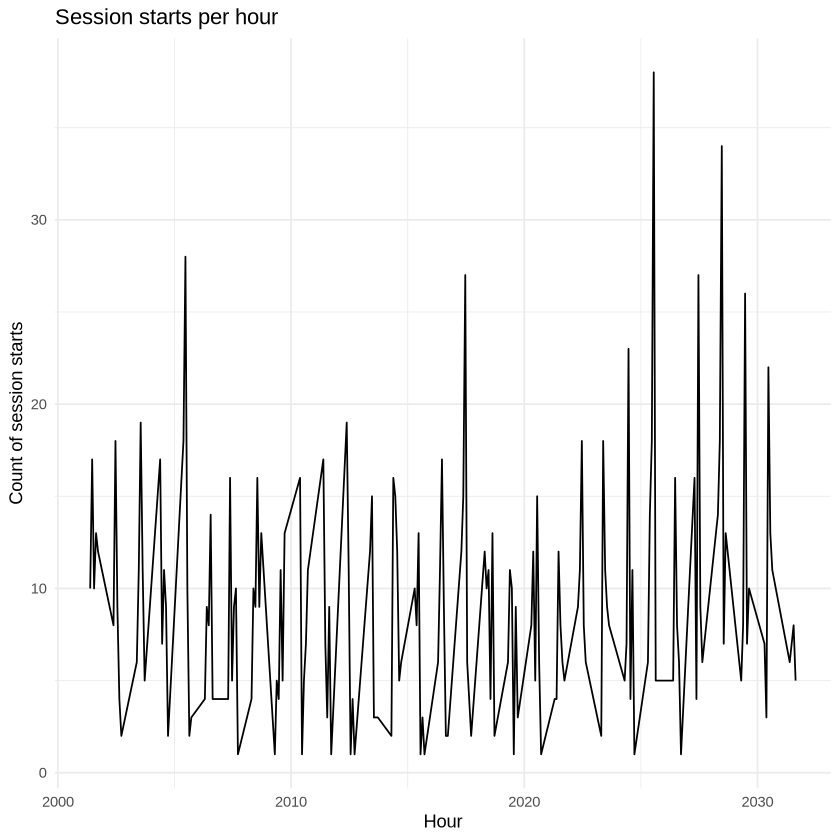

In [56]:
sessions_clean %>%
  count(hour = floor_date(start_ts, "hour")) %>%
  ggplot(aes(hour, n)) +
  geom_line() +
  labs(
    title = "Session starts per hour",
    x = "Hour",
    y = "Count of session starts"
  ) +
  theme_minimal()

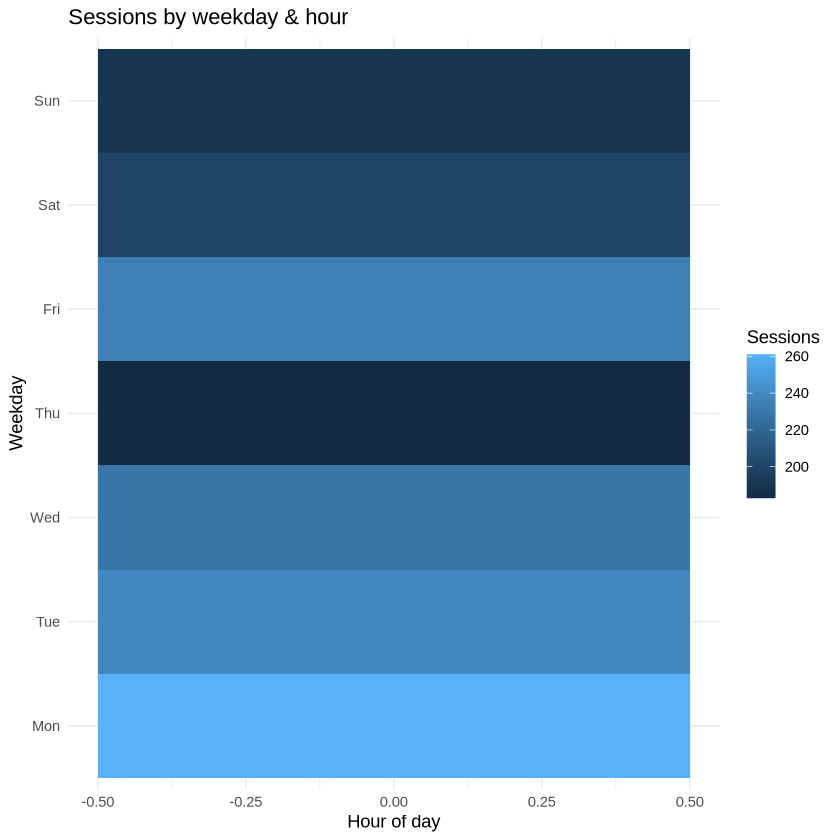

In [57]:
sessions |>
  count(wday, hour_of_day) |>
  ggplot(aes(hour_of_day, wday, fill = n)) +
  geom_tile() +
  labs(title = "Sessions by weekday & hour",
       x = "Hour of day", y = "Weekday", fill = "Sessions") +
  theme_minimal()

Individual Planning Report 
Author: Sam Ju 220198014
(1) Data Description

***(1) Data Description***

Variables (players.csv).

* Age (numeric)
  
* gender (categorical)

* experience (numeric scale as recorded)

* played_hours (numeric, self-reported cumulative playtime)

* subscribe (binary/categorical: newsletter sign-up)

* hashedEmail (key to join with sessions)

Variables (sessions.csv).

* start_time, end_time (datetimes; when parsing fails, original_start_time/original_end_time serve as fallbacks)

* hashedEmail (join key)

What I compute for description.

* Row/column counts for each file

* A variable dictionary (name + type)

* The mean for each quantitative variable in players.csv (rounded to 2 d.p., per instructions)


**Datasets**: I read the two CSV files, players.csv (one row per player) and sessions.csv (one row per play session). Juptyter reads both from GitHub raw URLs so it could be reproduced without without local files

**Dimensions & variables**: In players.csv, the key fields are Age (numeric), gender (categorical), experience (numeric scale as recorded), played_hours (numeric self-reported cumulative playtime), subscribe (binary/categorical target), and hashedEmail (join key). In sessions.csv the key fields are: start_time, end_time (datetimes), and hashedEmail (join key).

**Summary statistics**: Per the assignment, I compute the mean for each quantitative variable in players.csv to 2 decimal places.

***(2) Questions***

**Broad question**: Which player characteristics and behaviours are most predictive of subscribing to a game-related newsletter?

**Specific question**: Do demographics (Age, gender), gaming experience (experience, played_hours), and simple session-level aggregates (e.g., number of sessions and total minutes played) help predict whether a player subscribes in this dataset?

**Why these data help**: players.csv contains the target and sessions.csv adds behavioural signal that can be aggregated by hashedEmail and joined to players for exploration.

***(3) Exploratory Data Analysis and Visualization***

I plotted session starts over time (counted per clock hour) and a weekday–hour heatmap. The hourly time-series shows a spiky pattern (0–35 starts/hour) with irregular gaps and jumps rather than a smooth daily rhythm, indicating uneven activity over the timeline. To study behavioral cycles later, we should aggregate by hour-of-day or weekday rather than raw timestamps. The heatmap currently collapses along the hour axis so it effectively reports totals by weekday: Thursday is the busiest and Monday the quietest in this sample.


***(4) Methods and Plan***

Method：A baseline logistic regression (glm, family = binomial) to predict subscribe.

Why appropriate：The outcome is binary; coefficients are interpretable as odds ratios, letting stakeholders see which factors matter and in what direction.

Planned predictors： 

* From players.csv: Age, gender, experience, played_hours.

* From sessions.csv (per player): number of sessions, total minutes, mean session length, and—if hour data are available—share of evening (18–23h) and weekend sessions. If hours are unavailable, I will substitute weekday share and daily activity rate.

Processing"
Parse timestamps with fallbacks; remove impossible durations; aggregate sessions by player; left-join to players; median-impute numeric NAs; add an explicit “missing” level for categorical NAs; cap extreme outliers only if they distort fit. Because the subscription timestamp is unknown, I will treat behaviour as a general tendency and note potential leakage.

Assumptions to check: 
Independent players; approximate linearity of numeric predictors on the log-odds scale (use simple bins/transformations if needed); absence of perfect separation.

Model selection & evaluation:
Use a stratified 80/20 train–test split (seeded). Choose the operating threshold on the training set via Youden’s J. On the test set, report the confusion matrix, accuracy, and ROC/AUC; add a quick calibration check. If classes are imbalanced, emphasize AUC and adjust the threshold accordingly.